In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from PIL import Image

# ---------------------------
# PARAMETERS
# ---------------------------
Mm = 1e6  # meters per Mm
domain_size_Mm = 100.0   # full cubic domain size in Mm (100 Mm each side)
N = 100                  # points per axis (100^3 points -> 1e6)
L = 30.0                 # Mm (used for charge x-position half-separation)
d = 10.0                 # Mm (depth under photosphere)
q_Mm2 = 10              # q in T·Mm^2 (102 -> 1e2)
# convert q to SI units T·m^2
q = q_Mm2 * (Mm**2)      # q in T·m^2

# ---------------------------
# GRID (in Mm, then convert to m)
# ---------------------------
# let x,y,z range from -domain/2 to +domain/2 so z=0 is inside grid
half = domain_size_Mm / 2.0
x = np.linspace(-half, half, N)  # Mm
y = np.linspace(-half, half, N)  # Mm
z = np.linspace(-half, half, N)  # Mm
X, Y = np.meshgrid(x, y, indexing='xy')  # for plotting plane at z=0

# For full 3D computation we create 3D coordinate arrays (in meters)
xx = x * Mm
yy = y * Mm
zz = z * Mm

# create 3D mesh (N=100 => 1e6 points)
X3, Y3, Z3 = np.meshgrid(xx, yy, zz, indexing='xy')  # shapes (N,N,N) in meters

# ---------------------------
# CHARGE POSITIONS (meters)
# ---------------------------
# place charges at x = +/- L/2 (Mm), y=0, z = -d (under photosphere)
xpos = (L / 2.0) * Mm
negpos = -xpos
ypos = 0.0
zcharge = -d * Mm  # under photosphere

r1_pos = np.array([xpos, ypos, zcharge])
r2_pos = np.array([negpos, ypos, zcharge])

# ---------------------------
# COMPUTE Bq FIELD (vectorized)
# B = q * (r - r0) / |r - r0|^3 --> r₀ = position of the charge, r = position of the point in space
# r0 = [x_charge, y_charge, z_charge] (source location), r = (X, Y, Z) = grid of field-point coordinates (observation point)
# ∣r−r0​∣^3 = r3 = [(x−x0​)^2+(y−y0​)^2+(z−z0​)^2]^3/2 --> 3/2=1.5
# ---------------------------
eps = 1e-9  # small softening to avoid division by zero (in meters)

def compute_B_from_charge(q, r0, X, Y, Z):
    rx = X - r0[0]     # --> (r - r0) [displacement vector]
    ry = Y - r0[1]
    rz = Z - r0[2]
    r3 = (rx**2 + ry**2 + rz**2) ** 1.5 + eps   # --> |r - r0|^3
    Bxq = q * rx / r3
    Byq = q * ry / r3
    Bzq = q * rz / r3
    return Bxq, Byq, Bzq

# compute B from both charges and sum
Bx1, By1, Bz1 = compute_B_from_charge(q, r1_pos, X3, Y3, Z3)
Bx2, By2, Bz2 = compute_B_from_charge(-q, r2_pos, X3, Y3, Z3)  # second charge opposite sign
# note: for a bipolar configuration we give second opposite sign (common for TD toy-model)
Bxq = Bx1 + Bx2
Byq = By1 + By2
Bzq = Bz1 + Bz2

# -------------------------------
# calculation for ring current I
# -------------------------------

import numpy as np

def compute_ring_current(R_Mm, a_Mm, L_Mm, q_Mm2, li):
    Mm = 1e6
    mu0 = 4e-7 * np.pi  # permeability of free space

    # convert to meters
    R = R_Mm * Mm
    a = a_Mm * Mm
    L = L_Mm * Mm

    # q in T·m²
    q = q_Mm2 * (Mm**2)

    numerator = 8 * np.pi * q * L * R * (R**2 + L**2)**(-1.5)
    denominator = mu0 * (np.log(8 * R / a) - 1.5 + li / 2)

    I = numerator / denominator
    return I

# ---- call the function OUTSIDE the definition ----
I = compute_ring_current(R_Mm=20, a_Mm=5, L_Mm=50, q_Mm2=10, li=0.5)

print("Ring current I =", I, "A")

Ring current I = 577982918926.0006 A


In [86]:
import numpy as np

Mm = 1e6
R_Mm  = 20.0
R = R_Mm * Mm
a_Mm = 5.0
a = a_Mm * Mm
d_Mm = 10.0
d = d_Mm * Mm
mu0 = 4e-7 * np.pi  # permeability of free space

I0 = -0.2 * I

# -------------------------------
# Compute local TD geometry for inside rope
# -------------------------------
# Toroidal angle in Y–Z plane
phi = np.arctan2(Z3 + d, Y3)

# Torus axis (circle in Y–Z plane)
x0 = np.zeros_like(X3)
y0 = R * np.cos(phi)
z0 = -d + R * np.sin(phi)

# Vector from torus axis to grid point
rx = X3 - x0
ry = Y3 - y0
rz = Z3 - z0

rho = np.sqrt(rx**2 + ry**2 + rz**2)
rho = np.where(rho == 0, 1e-9, rho)

# -------------------------------
# Toroidal unit vector 𝑒^𝜙
# -------------------------------

# tubal coordinates (𝜌,𝜙,𝜃)
# e^ϕ (toroidal) - along the rope, 𝑒^𝜌 (radial) - Distance measured by 𝜌; Points away from the tube axis,
# e^θ (poloidal) - Runs around the tube cross-section ; Always perpendicular to:the axis (𝑒^𝜙) and the radial direction (𝑒^𝜌)


# vectors : shape (Nx, Ny, Nz, 3)
e_phi_vec = np.stack(    (np.zeros_like(phi), -np.sin(phi), np.cos(phi)),    axis=-1)

# -------------------------------
# Poloidal unit vector 𝑒^𝜃 ; e^θ​=e^𝜙​×e^ρ​
# -------------------------------

e_rho_vec = np.stack(    (rx/rho, ry/rho, rz/rho),    axis=-1)

# Cross product → poloidal direction
e_theta_vec = np.cross(e_phi_vec, e_rho_vec)

# Split back into components
e_theta = np.array([    e_theta_vec[..., 0],    e_theta_vec[..., 1],    e_theta_vec[..., 2]])

# -------------------------------
# Toroidal field (Eq. 12)
# -------------------------------

Bphi = np.zeros_like(rho)
inside = rho < a

Bphi[inside] = mu0 * I * rho[inside] / (2*np.pi*a**2)

# -------------------------------
# Poloidal field (Eq. 13)
# -------------------------------

B0m = mu0 * I0 / (2*np.pi*R)

Btheta = np.zeros_like(rho)
Btheta[inside] = np.sign(I0) * np.sqrt(
    B0m**2 +
    (mu0**2 * I**2 / (2*np.pi**2 * a**4)) *
    (a**2 - rho[inside]**2)
)
# -------------------------------
# Convert back to Cartesian components
# -------------------------------

Bx_rope = Bphi * e_phi_vec[...,0] + Btheta * e_theta[0]
By_rope = Bphi * e_phi_vec[...,1] + Btheta * e_theta[1]
Bz_rope = Bphi * e_phi_vec[...,2] + Btheta * e_theta[2]

# Outside rho > a, rope field must be zero:
Bx_rope[~inside] = 0.0
By_rope[~inside] = 0.0
Bz_rope[~inside] = 0.0

# Final field
Bxf = Bx_rope
Byf = By_rope
Bzf = Bz_rope

In [ ]:
# -------------------------------
# Orthogonality Check
# -------------------------------

# 1
print(np.max(np.abs(
    e_phi_vec[...,0]*e_rho_vec[...,0] +
    e_phi_vec[...,1]*e_rho_vec[...,1] +
    e_phi_vec[...,2]*e_rho_vec[...,2]
)))

# 2
print(np.max(np.abs(
    e_phi_vec[...,0]*e_theta_vec[...,0] +
    e_phi_vec[...,1]*e_theta_vec[...,1] +
    e_phi_vec[...,2]*e_theta_vec[...,2]
)))

# 3 - Unit length
print(np.max(np.abs(np.linalg.norm(e_theta_vec, axis=-1) - 1)))


1.0269562977782698e-14
1.1102230246251565e-16
4.440892098500626e-16


In [104]:
# ---------------------------
# DECAY INDEX CALCULATION
# ---------------------------

# 1. Horizontal component of B
B_ex = np.sqrt(Bxq**2 + Byq**2)  # shape (N,N,N)

# 2. Logarithm
lnB = np.log(B_ex + eps)  # avoid log(0) using eps

# 3. Finite difference along z-axis
# Z3 shape = (N,N,N), axis=2 corresponds to z
# np.gradient returns derivative w.r.t. each axis (in meters)
dlnB_dz = np.gradient(lnB, zz, axis=2)  # shape (N,N,N)

# 4. Decay index n = - d ln B / d ln z = - z * d ln B / dz
# use Z3 as z coordinate (in meters)
n_decay = - Z3 * dlnB_dz

# 5. Optional: slice at z=0 plane for plotting
z0_index = N // 2  # index corresponding to z=0
n_slice = n_decay[:, :, z0_index]  # shape (N,N) at z=0

# Convert to float32 to reduce file size
n_decay_f32 = n_decay.astype(np.float32)

# File path
file_path = r"C:/Users/maitr/Downloads/vapor-td-mfr/case10/DI.raw"

# Save as raw binary
n_decay_f32.tofile(file_path)

print(f"Saved decay index raw file to: {file_path}")



Saved decay index raw file to: C:/Users/maitr/Downloads/vapor-td-mfr/case10/DI.raw


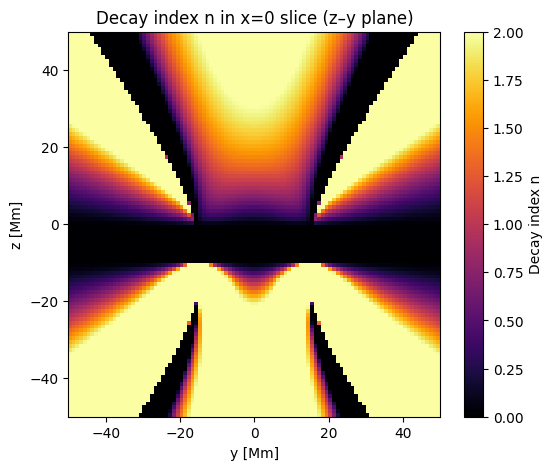

In [103]:
# index corresponding to x=0 plane
x0_index = N // 2  

# slice decay index along x=0 plane: shape (N, N) => (y, z)
n_slice_x0 = n_decay[x0_index, :, :]  # axes: y, z

Y_slice = Y3[x0_index, :, :] / Mm  # in Mm
Z_slice = Z3[x0_index, :, :] / Mm  # in Mm

plt.figure(figsize=(6,5))
plt.imshow(n_slice_x0.T, origin='lower',
           extent=[y.min(), y.max(), z.min(), z.max()],
           aspect='auto', cmap='inferno', vmin=0, vmax=2)
plt.colorbar(label='Decay index n')
plt.xlabel('y [Mm]')
plt.ylabel('z [Mm]')
plt.title('Decay index n in x=0 slice (z–y plane)')
plt.show()


In [87]:
import numpy as np

# X3, Y3, Z3 = np.meshgrid(xx, yy, zz, indexing='xy') ---> This gives axes in order (Y, X, Z)
#but VAPOR expects (Z, Y, X)
# To convert (Y, X, Z) → (Z, Y, X) use:

Bx_vapor = np.transpose(Bxq, (2,0,1))
By_vapor = np.transpose(Byq, (2,0,1))
Bz_vapor = np.transpose(Bzq, (2,0,1))

import os
save_path = r"C:/Users/maitr/Downloads/vapor-td-mfr/case10/"

# Save as float32
Bx_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bxq.raw"))
By_vapor.astype(np.float32).tofile(os.path.join(save_path, "Byq.raw"))
Bz_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bzq.raw"))

In [88]:
import numpy as np

# X3, Y3, Z3 = np.meshgrid(xx, yy, zz, indexing='xy') ---> This gives axes in order (Y, X, Z)
#but VAPOR expects (Z, Y, X)
# To convert (Y, X, Z) → (Z, Y, X) use:

Bx_vapor = np.transpose(Bxf, (2,0,1))
By_vapor = np.transpose(Byf, (2,0,1))
Bz_vapor = np.transpose(Bzf, (2,0,1))

import os
save_path = r"C:/Users/maitr/Downloads/vapor-td-mfr/case10/"

# Save as float32
Bx_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bxf.raw"))
By_vapor.astype(np.float32).tofile(os.path.join(save_path, "Byf.raw"))
Bz_vapor.astype(np.float32).tofile(os.path.join(save_path, "Bzf.raw"))